In [1]:
import os
import numpy as np
import pandas as pd
import pyBigWig
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import subprocess
import zipfile


## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define paths for the data
path_data = "/mnt/c/Users/sigls/Downloads/ML4G_Project_1_Data"

# Define the paths for the training and validation files for X1 and X2
# Training data paths
path_X1_train_y = f"{path_data}/CAGE-train/CAGE-train/X1_train_y.tsv"
path_X2_train_y = f"{path_data}/CAGE-train/CAGE-train/X2_train_y.tsv"
path_X1_train_info = f"{path_data}/CAGE-train/CAGE-train/X1_train_info.tsv"
path_X2_train_info = f"{path_data}/CAGE-train/CAGE-train/X2_train_info.tsv"

# Validation data paths
path_X1_val_y = f"{path_data}/CAGE-train/CAGE-train/X1_val_y.tsv"
path_X2_val_y = f"{path_data}/CAGE-train/CAGE-train/X2_val_y.tsv"
path_X1_val_info = f"{path_data}/CAGE-train/CAGE-train/X1_val_info.tsv"
path_X2_val_info = f"{path_data}/CAGE-train/CAGE-train/X2_val_info.tsv"

# Load training genes and train info for X1 and X2
X1_train_genes = pd.read_csv(path_X1_train_y, sep='\t')
X2_train_genes = pd.read_csv(path_X2_train_y, sep='\t')
X1_train_info = pd.read_csv(path_X1_train_info, sep='\t')
X2_train_info = pd.read_csv(path_X2_train_info, sep='\t')

# Merge training genes with train info by 'gene_name'
X1_train_merged = pd.merge(X1_train_genes, X1_train_info, on='gene_name')
X2_train_merged = pd.merge(X2_train_genes, X2_train_info, on='gene_name')

# Handle negative 'gex' values (clip to zero)
X1_train_merged['gex'] = X1_train_merged['gex'].clip(lower=0)
X2_train_merged['gex'] = X2_train_merged['gex'].clip(lower=0)

# Add a 'cell_line' column to identify the source before combining
X1_train_merged['cell_line'] = 'X1'
X2_train_merged['cell_line'] = 'X2'

# Combine training data from X1 and X2
train_data = pd.concat([X1_train_merged, X2_train_merged], ignore_index=True)

# Load validation genes and validation info for X1 and X2
X1_val_genes = pd.read_csv(path_X1_val_y, sep='\t')
X2_val_genes = pd.read_csv(path_X2_val_y, sep='\t')
X1_val_info = pd.read_csv(path_X1_val_info, sep='\t')
X2_val_info = pd.read_csv(path_X2_val_info, sep='\t')

# Merge validation genes with validation info by 'gene_name'
X1_val_merged = pd.merge(X1_val_genes, X1_val_info, on='gene_name')
X2_val_merged = pd.merge(X2_val_genes, X2_val_info, on='gene_name')

# Handle negative 'gex' values (clip to zero)
X1_val_merged['gex'] = X1_val_merged['gex'].clip(lower=0)
X2_val_merged['gex'] = X2_val_merged['gex'].clip(lower=0)

# Add a 'cell_line' column to identify the source before combining
X1_val_merged['cell_line'] = 'X1'
X2_val_merged['cell_line'] = 'X2'

# Combine validation data from X1 and X2
val_data = pd.concat([X1_val_merged, X2_val_merged], ignore_index=True)

# Define BigWig file paths for all marks and DNase
def get_bigwig_path(mark, cell_line):
    directory = f"{path_data}/{mark}-bigwig"
    for ext in ['bigwig', 'bw']:
        filename = f"{cell_line}.{ext}"
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            return filepath
    raise FileNotFoundError(f"{cell_line} BigWig file not found in {directory}")

# List of all marks to be included
marks = ["H3K4me3", "H3K27ac", "H3K27me3", "H3K36me3", "DNase"]

# Create BigWig paths for all marks and cell lines (X1, X2)
bigwig_paths = {}
for mark in marks:
    bigwig_paths[mark] = {}
    for cell_line in ['X1', 'X2']:
        try:
            bigwig_paths[mark][cell_line] = get_bigwig_path(mark, cell_line)
        except FileNotFoundError as e:
            print(e)
            bigwig_paths[mark][cell_line] = None  # Handle missing files by setting to None

# Feature extraction function with spatial positions
def extract_sequence_features(genes, bigwig_file, region_size=2000, bin_size=100):
    features = []
    positions = []
    half_region = region_size // 2
    num_bins = region_size // bin_size
    chrom_sizes = bigwig_file.chroms()
    for _, row in genes.iterrows():
        chrom = str(row['chr'])
        tss = int(row['TSS_start'])
        chrom_length = chrom_sizes.get(chrom)
        if chrom_length is None:
            print(f"Chromosome {chrom} not found in BigWig file.")
            continue
        start = max(0, tss - half_region)
        end = min(tss + half_region, chrom_length)
        bins = np.linspace(start, end, num=num_bins+1, dtype=int)
        bin_centers = (bins[:-1] + bins[1:]) / 2 - tss  # Distance from TSS
        signal_values = []
        for i in range(len(bins)-1):
            bin_start = bins[i]
            bin_end = bins[i+1]
            try:
                signal = bigwig_file.stats(chrom, bin_start, bin_end, type='mean')
                if signal is None or signal[0] is None or np.isnan(signal[0]):
                    signal_values.append(0.0)
                else:
                    signal_values.append(signal[0])
            except Exception as e:
                print(f"Error for {chrom}:{bin_start}-{bin_end} - {e}")
                signal_values.append(0.0)
        features.append(signal_values)
        positions.append(bin_centers)
    return np.array(features), np.array(positions)  # Both shapes: (num_genes, num_bins)

# Modified feature extraction function to handle missing BigWig files
def extract_all_sequence_features_with_missing(merged_data, cell_line):
    features_list = []
    positions = None  # We'll use the positions from the first valid mark
    for mark in marks:
        bw_path = bigwig_paths[mark].get(cell_line)
        if bw_path is not None and os.path.isfile(bw_path):
            try:
                bw_file = pyBigWig.open(bw_path)
                features, pos = extract_sequence_features(merged_data, bw_file)
                features_list.append(features)
                if positions is None:
                    positions = pos
                bw_file.close()
            except Exception as e:
                print(f"Error opening BigWig file for {mark} in {cell_line}: {e}")
                # Fill with zeros if error occurs
                num_genes = len(merged_data)
                num_bins = 2000 // 100
                features = np.zeros((num_genes, num_bins))
                features_list.append(features)
                if positions is None:
                    positions = np.linspace(-1000 + 50, 1000 - 50, num=20)  # Example positions
        else:
            print(f"BigWig file for mark {mark} in cell line {cell_line} not found. Filling with zeros.")
            num_genes = len(merged_data)
            num_bins = 2000 // 100
            features = np.zeros((num_genes, num_bins))
            features_list.append(features)
            if positions is None:
                positions = np.linspace(-1000 + 50, 1000 - 50, num=20)  # Example positions
    features_array = np.stack(features_list, axis=1)
    return features_array, positions

# Function to extract features and labels from a dataset
def get_features_and_labels(data):
    # Split data by cell line
    data_X1 = data[data['cell_line'] == 'X1']
    data_X2 = data[data['cell_line'] == 'X2']
    
    # Extract features and positions for X1
    features_X1, positions_X1 = extract_all_sequence_features_with_missing(data_X1, "X1")
    
    # Extract features and positions for X2
    features_X2, positions_X2 = extract_all_sequence_features_with_missing(data_X2, "X2")
    
    # Combine features and positions from X1 and X2
    features = np.concatenate([features_X1, features_X2], axis=0)
    positions = np.concatenate([positions_X1, positions_X2], axis=0)
    
    # Replace NaNs in features
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Get labels
    labels_X1 = np.log1p(data_X1['gex'].values)
    labels_X2 = np.log1p(data_X2['gex'].values)
    labels = np.concatenate([labels_X1, labels_X2], axis=0).reshape(-1, 1)
    
    # Replace NaNs and infinite values in labels
    labels = np.nan_to_num(labels, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features, positions, labels

# Extract training features and labels
print("Extracting training features...")
train_features_np, train_positions_np, train_labels_np = get_features_and_labels(train_data)

# Extract validation features and labels
print("Extracting validation features...")
val_features_np, val_positions_np, val_labels_np = get_features_and_labels(val_data)

# Define the paths for the test info file for X3 (no gex file as we are predicting it)
path_X3_info = f"{path_data}/CAGE-train/CAGE-train/X3_test_info.tsv"

# Load test info for X3
X3_test_info = pd.read_csv(path_X3_info, sep='\t')

# Add a 'cell_line' column to identify the source
X3_test_info['cell_line'] = 'X3'

# Add 'X3' to bigwig_paths
for mark in marks:
    try:
        bigwig_paths[mark]["X3"] = get_bigwig_path(mark, "X3")
    except FileNotFoundError:
        print(f"BigWig file for mark {mark} in cell line X3 not found. Filling features with zeros.")
        bigwig_paths[mark]["X3"] = None  # Handle missing files by setting to None

# Extract features and positions for X3
print("Extracting test features...")
test_features_np, test_positions_np = extract_all_sequence_features_with_missing(X3_test_info, "X3")

# Reshape features for scaling
num_train_samples, num_marks, num_bins = train_features_np.shape
train_features_np_reshaped = train_features_np.reshape(num_train_samples, -1)

num_test_samples = test_features_np.shape[0]
test_features_np_reshaped = test_features_np.reshape(num_test_samples, -1)

# Combine training and test features for scaling
combined_features_np_reshaped = np.concatenate([train_features_np_reshaped, test_features_np_reshaped], axis=0)

# Fit scaler on combined features
scaler = StandardScaler()
scaler.fit(combined_features_np_reshaped)

# Transform training features
train_features_np_scaled = scaler.transform(train_features_np_reshaped)
train_features_np_scaled = train_features_np_scaled.reshape(num_train_samples, num_marks, num_bins)

# Transform test features
test_features_np_scaled = scaler.transform(test_features_np_reshaped)
test_features_np_scaled = test_features_np_scaled.reshape(num_test_samples, num_marks, num_bins)

# Reshape and scale validation features
num_val_samples = val_features_np.shape[0]
val_features_np_reshaped = val_features_np.reshape(num_val_samples, -1)
val_features_np_scaled = scaler.transform(val_features_np_reshaped)
val_features_np_scaled = val_features_np_scaled.reshape(num_val_samples, num_marks, num_bins)

# Convert positions to distances (already done)
train_positions_np = train_positions_np  # Shape: (num_samples, num_bins)
val_positions_np = val_positions_np
test_positions_np = test_positions_np

# Convert to PyTorch tensors
train_features = torch.tensor(train_features_np_scaled, dtype=torch.float32)
train_positions = torch.tensor(train_positions_np, dtype=torch.float32)
train_labels = torch.tensor(train_labels_np, dtype=torch.float32)

val_features = torch.tensor(val_features_np_scaled, dtype=torch.float32)
val_positions = torch.tensor(val_positions_np, dtype=torch.float32)
val_labels = torch.tensor(val_labels_np, dtype=torch.float32)

test_features = torch.tensor(test_features_np_scaled, dtype=torch.float32)
test_positions = torch.tensor(test_positions_np, dtype=torch.float32)

# Create DataLoader for training set
train_dataset = TensorDataset(train_features, train_positions, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Extracting training features...
Extracting validation features...
Extracting test features...


## Work Package 1.2 - Model Building

Epoch 1, Training Loss: 1.9782, Validation Loss: 1.8901, Validation Spearman's correlation: 75.35%
Validation loss decreased (inf --> 1.890101).  Saving model ...
Epoch 5, Training Loss: 1.3639, Validation Loss: 1.5785, Validation Spearman's correlation: 80.25%
Validation loss decreased (1.890101 --> 1.578467).  Saving model ...
Epoch 10, Training Loss: 1.2956, Validation Loss: 1.6011, Validation Spearman's correlation: 80.58%
EarlyStopping counter: 1 out of 10
Epoch 15, Training Loss: 1.2430, Validation Loss: 1.3869, Validation Spearman's correlation: 81.30%
Validation loss decreased (1.578467 --> 1.386942).  Saving model ...
Epoch 20, Training Loss: 1.2101, Validation Loss: 1.3816, Validation Spearman's correlation: 81.41%
Validation loss decreased (1.386942 --> 1.381636).  Saving model ...
Epoch 25, Training Loss: 1.1940, Validation Loss: 1.3838, Validation Spearman's correlation: 81.51%
EarlyStopping counter: 1 out of 10
Epoch 30, Training Loss: 1.1742, Validation Loss: 1.3398, Val

/tmp/ipykernel_22126/3072187914.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Validation Loss: 1.3163
Final Validation Spearman's correlation: 81.88%
Spearman's correlation is over 68.5%: 81.88%


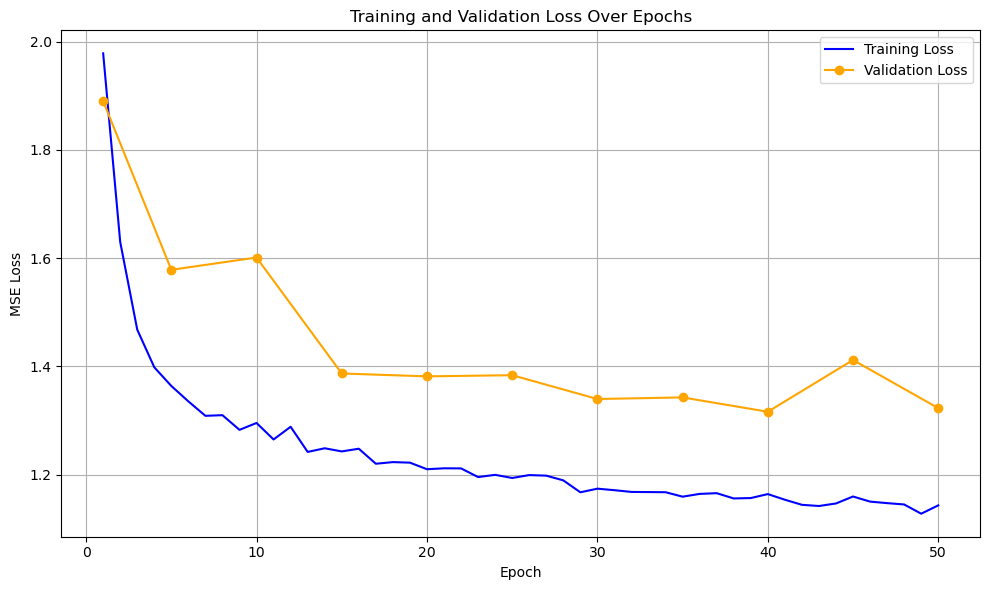

In [3]:
# Define the CNN-LSTM model with spatial weighting and learnable decay rate
class CNNLSTMModel(nn.Module):
    def __init__(self, num_marks, num_bins):
        super(CNNLSTMModel, self).__init__()
        self.num_marks = num_marks
        self.num_bins = num_bins
        # Learnable decay rate parameter (initialized to 0.001)
        self.decay_rate = nn.Parameter(torch.tensor(0.001, dtype=torch.float32))
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=num_marks, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)  # Added BatchNorm
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)  # Added BatchNorm
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x, positions):
        # x shape: (batch_size, num_marks, num_bins)
        # positions shape: (batch_size, num_bins)
        # Apply exponential decay weighting
        decay_weights = torch.exp(-torch.abs(positions) * torch.abs(self.decay_rate))
        decay_weights = decay_weights.unsqueeze(1)  # Shape: (batch_size, 1, num_bins)
        x = x * decay_weights  # Apply weights to features
        
        x = self.conv1(x)
        x = self.bn1(x)  # Apply BatchNorm
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply BatchNorm
        x = torch.relu(x)
        x = self.pool(x)  # Shape: (batch_size, out_channels, new_seq_length)
        x = self.dropout(x)
        
        # Prepare input for LSTM
        x = x.permute(0, 2, 1)  # Shape: (batch_size, seq_length, features)
        
        # LSTM layer
        out, (hn, cn) = self.lstm(x)
        out = hn[-1]
        out = self.dropout(out)
        
        # Fully connected layer
        out = self.fc(out)
        return out

# Initialize the model, loss, and optimizer
num_marks = len(marks)
num_bins = train_features_np_scaled.shape[2]
model = CNNLSTMModel(num_marks=num_marks, num_bins=num_bins)
criterion = nn.MSELoss()

# Initialize the optimizer with increased weight_decay for stronger L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0.0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_loss = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss  # We want to minimize validation loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_val_loss = val_loss

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=10, verbose=True, delta=0.0, path='best_model.pth')

# Initialize lists to store metrics
train_losses = []
val_losses = []

# Create DataLoader for validation set
val_dataset = TensorDataset(val_features, val_positions, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop with validation and Early Stopping
epochs = 50  # Maximum number of epochs
best_spearman = -1
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, positions, targets in train_loader:
        inputs = inputs.to(device)
        positions = positions.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, positions)
        loss = criterion(outputs, targets)
        if torch.isnan(loss):
            print("Encountered NaN loss, skipping this batch")
            continue
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Record training loss
    
    # Evaluate on validation set every 5 epochs and on the first epoch
    if (epoch+1) % 5 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_predictions = []
            val_true = []
            for val_inputs_batch, val_positions_batch, val_targets_batch in val_loader:
                val_inputs_batch = val_inputs_batch.to(device)
                val_positions_batch = val_positions_batch.to(device)
                val_targets_batch = val_targets_batch.to(device)
                val_outputs_batch = model(val_inputs_batch, val_positions_batch)
                loss = criterion(val_outputs_batch, val_targets_batch)
                val_running_loss += loss.item()
                val_predictions.extend(val_outputs_batch.cpu().numpy().squeeze())
                val_true.extend(val_targets_batch.cpu().numpy().squeeze())
            avg_val_loss = val_running_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Record validation loss
            spearman_corr, _ = spearmanr(val_predictions, val_true)
            spearman_corr_percent = spearman_corr * 100
            if spearman_corr > best_spearman:
                best_spearman = spearman_corr
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Spearman's correlation: {spearman_corr_percent:.2f}%")
            
            # Call EarlyStopping
            early_stopping(avg_val_loss, model)
            
            if early_stopping.early_stop:
                print("Early stopping triggered. Stopping training.")
                break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Final evaluation on validation set
model.eval()
with torch.no_grad():
    val_running_loss = 0.0
    val_predictions = []
    val_true = []
    for val_inputs_batch, val_positions_batch, val_targets_batch in val_loader:
        val_inputs_batch = val_inputs_batch.to(device)
        val_positions_batch = val_positions_batch.to(device)
        val_targets_batch = val_targets_batch.to(device)
        val_outputs_batch = model(val_inputs_batch, val_positions_batch)
        loss = criterion(val_outputs_batch, val_targets_batch)
        val_running_loss += loss.item()
        val_predictions.extend(val_outputs_batch.cpu().numpy().squeeze())
        val_true.extend(val_targets_batch.cpu().numpy().squeeze())
    avg_val_loss = val_running_loss / len(val_loader)
    spearman_corr, _ = spearmanr(val_predictions, val_true)
    spearman_corr_percent = spearman_corr * 100
    print(f"Final Validation Loss: {avg_val_loss:.4f}")
    print(f"Final Validation Spearman's correlation: {spearman_corr_percent:.2f}%")
    
# Check if the Spearman's correlation is over 68.5%
if spearman_corr_percent >= 68.5:
    print(f"Spearman's correlation is over 68.5%: {spearman_corr_percent:.2f}%")
else:
    print(f"Spearman's correlation is below 68.5%: {spearman_corr_percent:.2f}%")

# Plotting the Training Loss and Validation Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, epoch + 2)  # +2 to include the epoch where early stopping was triggered

# Plot Training Loss
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')

# Define validation_epochs as [1, 5, 10, ..., epoch+1]
validation_epochs = [1] + list(range(5, epoch + 2, 5))

# Ensure that validation_epochs includes the final epoch
if (epoch + 1) not in validation_epochs:
    validation_epochs.append(epoch + 1)

# Ensure that validation_epochs matches the length of val_losses
if len(validation_epochs) > len(val_losses):
    validation_epochs = validation_epochs[:len(val_losses)]
elif len(validation_epochs) < len(val_losses):
    # This shouldn't happen, but just in case
    validation_epochs = validation_epochs + [epochs_range[-1]] * (len(val_losses) - len(validation_epochs))

# Plot Validation Loss
plt.plot(validation_epochs, val_losses, label='Validation Loss', color='orange', marker='o')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

In [4]:
# ---------------------------------------------------------------------------
# Prediction on X3

# Convert test features and positions to PyTorch tensors
test_features = test_features.to(device)
test_positions = test_positions.to(device)

# Make predictions for X3 without external spatial transformation
print("Making predictions on X3 test data...")
model.eval()
with torch.no_grad():
    outputs = model(test_features, test_positions)
    pred = outputs.cpu().numpy().squeeze()

# Revert log transformation
pred_original_scale = np.expm1(pred)

# Ensure predictions are valid
assert isinstance(pred_original_scale, np.ndarray), 'Prediction array must be a numpy array'
assert np.issubdtype(pred_original_scale.dtype, np.number), 'Prediction array must be numeric'
assert pred_original_scale.shape[0] == len(X3_test_info), 'Each gene should have a unique predicted expression'

# Prepare the DataFrame for saving
X3_test_info['gex_predicted'] = pred_original_scale.tolist()


Making predictions on X3 test data...


#### Store Predictions in the Required Format

In [5]:
# ---------------------------------------------------------------------------
# Save predictions and create ZIP file

# Define save directory and file names
save_dir = f"{path_data}/Predictions"  # Update this path as needed
os.makedirs(save_dir, exist_ok=True)
file_name = 'gex_predicted.csv'         # PLEASE DO NOT CHANGE THIS
zip_name = "Sigl_Simon_Project1.zip"    # Replace with your actual last and first name

# Prepare the DataFrame for saving
X3_test_info['gex_predicted'] = pred.tolist()

# Add a new column for numbering the rows starting from 0
X3_test_info[''] = range(len(X3_test_info))

# Rearrange columns to have the numbering column first
output_df = X3_test_info[['', 'gene_name', 'gex_predicted']]

# Save the CSV file
csv_path = os.path.join(save_dir, file_name)
output_df.to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")

# Create a ZIP file containing the CSV
zip_path = os.path.join(save_dir, zip_name)
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_path, arcname=file_name)
print(f"Predictions saved and zipped at: {zip_path}")

# ---------------------------------------------------------------------- #
# Additional steps to create a comprehensive ZIP file for submission
# Include the environment, README, Jupyter Notebook, and any other necessary files

# Define paths
environment_file = 'environment.yml'        # Will be generated by exporting the Conda environment
readme_file = 'README.md'                   # Optional: Create a README explaining your project
notebook_file = 'gen_exp_model.ipynb'       # Specify the path to your Jupyter Notebook

# Export the current Conda environment to environment.yml
try:
    print("Exporting the current Conda environment to environment.yml...")
    with open(environment_file, 'w') as f:
        subprocess.run(['conda', 'env', 'export'], stdout=f, check=True)
    print(f"Conda environment exported successfully to {environment_file}.")
except subprocess.CalledProcessError as e:
    print("An error occurred while exporting the Conda environment.")
    print(e)
except FileNotFoundError:
    print("Conda is not installed or not found in the system PATH.")

# Paths to include in the ZIP
additional_files = [environment_file, readme_file, notebook_file]

with zipfile.ZipFile(zip_path, 'a', zipfile.ZIP_DEFLATED) as zipf:
    for file in additional_files:
        if os.path.isfile(file):
            zipf.write(file, arcname=file)
            print(f"Added {file} to the ZIP.")
        else:
            print(f"File {file} not found. Skipping.")

print("All necessary files have been zipped successfully.")

Predictions saved to: /mnt/c/Users/sigls/Downloads/ML4G_Project_1_Data/Predictions/gex_predicted.csv
Predictions saved and zipped at: /mnt/c/Users/sigls/Downloads/ML4G_Project_1_Data/Predictions/Sigl_Simon_Project1.zip
Exporting the current Conda environment to environment.yml...
Conda environment exported successfully to environment.yml.
Added environment.yml to the ZIP.
File README.md not found. Skipping.
File gen_exp_model.ipynb not found. Skipping.
All necessary files have been zipped successfully.


/home/sigls/miniconda3/lib/python3.12/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
